### Simple input LIF_v_input_v_rev model with integer values only

In [1]:
import sys
#sys.path.append('/home/jovyan/brian2lava')
#sys.path.append('/home/carlo/Entwicklung/Python/brian2lava')
#sys.path.append('/home/francesco/Developing/B2L/brian2lava')
#sys.path.append('/homes/jlubo/brian2lava')

In [2]:
from brian2 import *

In [3]:
# Import Brian2Lava
import brian2lava

# Use included models directory
models_dir=None

# Use external models directory (containing ncProcessModels for Loihi)
#models_dir='/home/jlubo/brian2lava-models/models'

# Set device, choosing CPU with fixed-point representation, but switching off F2F conversion
set_device('lava', mode='preset', hardware='CPU', num_repr='fixed', use_f2f=False, models_dir=models_dir)
BrianLogger.log_level_debug()

In [4]:
# Import LIF model with delta-shaped voltage input
from brian2lava.preset_mode.model_loader import lif_v_input_v_rev

In [5]:
# Set scaling factor for fixed-point computation
scf = 1000

# Set seed
seed(1)

# Set defaultclock
defaultclock.dt = 1 * scf * ms

In [6]:
print(lif_v_input_v_rev.process_name)
print(lif_v_input_v_rev.description)
print(lif_v_input_v_rev.equations, type(lif_v_input_v_rev.equations))
print(lif_v_input_v_rev.conditions)

LIF_v_input_v_rev
Leaky Integrate-and-Fire neuron with refractory period, exponentially decaying voltage input, and specified reversal potential
dv/dt = (v_rev - v + v_psp + bias)/tau_v : V
dv_psp/dt = -v_psp/tau_psp : V
bias : V <class 'brian2.equations.equations.Equations'>
{'th': 'v > v_th', 'rs': 'v = v_rs'}


Model name (name of the Lava process)                                           
--------------------------------------------------------------------------------
lif_v_input_v_rev                                                               


Description                                                                     
--------------------------------------------------------------------------------
Leaky Integrate-and-Fire neuron with refractory period, exponentially decaying voltage input, and specified reversal potential


Model equations (rendered LaTeX)                                                
--------------------------------------------------------------------------------


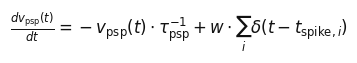

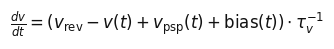

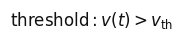

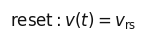



Brian 2 equations                                                               
--------------------------------------------------------------------------------
dv_psp/dt = -v_psp/tau_psp : volt                                               
dv/dt = (v_rev - v + v_psp + bias)/tau_v : volt                                 
bias : volt                                                                     


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : v > v_th                                                                   
rs : v = v_rs                                                                   


Refractory period                                                               
--------------------------------------------------------------------------------
<not supported>


Variables                                                                       
----

In [7]:
lif_v_input_v_rev.show()

In [8]:
# Define parameters
N = 3
bias_0 = 15 * mV/ms
tau_psp = 0 * scf * ms # delta_psp = dt / tau_psp * 2**12
tau_v = 10 * scf * ms
v_th = 35 * scf * mV
v_rs = -70 * scf * mV
v_rev = -65 * scf * mV

# Add a spike generator group
S = SpikeGeneratorGroup(3, [0, 0], [2, 6]*second) # <--- only works with N neurons!

# Add a neuron group
P = NeuronGroup(N, lif_v_input_v_rev.equations, threshold=lif_v_input_v_rev.conditions["th"], reset=lif_v_input_v_rev.conditions["rs"], method='euler')
#P.v_psp = "80 * scf * mV"
P.bias = bias_0 * tau_v # multiply with time constant to comply with B2L's standard "lif" model
P.v = v_rev + 2 * scf * mV

# Add another neuron group
Q = NeuronGroup(N, lif_v_input_v_rev.equations, threshold=lif_v_input_v_rev.conditions["th"], reset=lif_v_input_v_rev.conditions["rs"], method='euler')
#Q.v_psp = "0.1*mV"
Q.bias = bias_0 * tau_v # multiply with time constant to comply with B2L's standard "lif" model
Q.v = v_rev + 2 * scf * mV

# Add synapses
syn = Synapses(S, Q, model = 'w : volt', on_pre='v_post += w')
syn.connect(i=[0], j=[0,1,2])
syn.w = 50.0 * mV/ms * tau_v # multiply with time constant to comply with B2L's standard "lif" model

DEBUG      Creating synapses from group 'spikegeneratorgroup' to group 'neurongroup_1', using pre-defined arrays) [brian2.synapses.synapses]


In [9]:
device = get_device()
device.code_object_class()

brian2.codegen.runtime.numpy_rt.numpy_rt.NumpyCodeObject

In [10]:
# Add monitor for spikes
#sm = SpikeMonitor(P)
#spmP = SpikeMonitor(P, variables='v', record=[0])
spmP = SpikeMonitor(P, variables='v', record=True)
spmQ = SpikeMonitor(Q, variables='v', record=True)

# Add monitors for voltage and current
stmPv = StateMonitor(P, variables='v', record=True)
stmPv_psp = StateMonitor(P, variables='v_psp', record=True)
stmQv = StateMonitor(Q, variables='v', record=True)
stmQv_psp = StateMonitor(Q, variables='v_psp', record=True)

In [11]:
# Run simulation
#run(15*ms)
run(30 * scf * ms)

DEBUG      Updated MagicNetwork to include 17 objects with names neurongroup_spike_resetter, spikemonitor, neurongroup_1_stateupdater, statemonitor, neurongroup_spike_thresholder, statemonitor_2, neurongroup, neurongroup_1, statemonitor_3, neurongroup_1_spike_thresholder, spikegeneratorgroup, synapses_pre, spikemonitor_1, synapses, neurongroup_1_spike_resetter, statemonitor_1, neurongroup_stateupdater [brian2.core.magic.magic_objects]
DEBUG      Preparing network 'magicnetwork' with 17 objects: neurongroup, neurongroup_1, statemonitor, statemonitor_1, statemonitor_2, statemonitor_3, synapses, neurongroup_1_stateupdater, neurongroup_stateupdater, neurongroup_1_spike_thresholder, neurongroup_spike_thresholder, spikegeneratorgroup, spikemonitor, spikemonitor_1, synapses_pre, neurongroup_1_spike_resetter, neurongroup_spike_resetter [brian2.core.network.before_run]
DEBUG      Group neurongroup_1: using numerical integration method euler (took 0.01s) [brian2.stateupdaters.base.method_choice]

In [12]:
print(f"NeuronGroup P, neuron 0:")
print(f"  v(t=0)      =   {stmPv.v[0][0]/scf}")
print(f"  v_psp(t=0)  =   {stmPv_psp.v_psp[0][0]/scf}")
print(f"  v(t=-1)     =   {stmPv.v[0][-1]/scf}")
print(f"  v_psp(t=-1) =   {stmPv_psp.v_psp[0][-1]/scf}")
print(f"  v           =   {P.v[0]/scf}")
print(f"  v_psp       =   {P.v_psp[0]/scf}")
print(f"NeuronGroup Q, neuron 0:")
print(f"  v(t=0)      =   {stmQv.v[0][0]/scf}")
print(f"  v_psp(t=0)  =   {stmQv_psp.v_psp[0][0]/scf}")
print(f"  v(t=-1)     =   {stmQv.v[0][-1]/scf}")
print(f"  v_psp(t=-1) =   {stmQv_psp.v_psp[0][-1]/scf}")
print(f"  v           =   {Q.v[0]/scf}")
print(f"  v_psp       =   {Q.v_psp[0]/scf}")

NeuronGroup P, neuron 0:
  v(t=0)      =   -63. mV
  v_psp(t=0)  =   0. V
  v(t=-1)     =   -6. mV
  v_psp(t=-1) =   0. V
  v           =   3. mV
  v_psp       =   0. V
NeuronGroup Q, neuron 0:
  v(t=0)      =   -63. mV
  v_psp(t=0)  =   0. V
  v(t=-1)     =   16. mV
  v_psp(t=-1) =   0. V
  v           =   22. mV
  v_psp       =   0. V


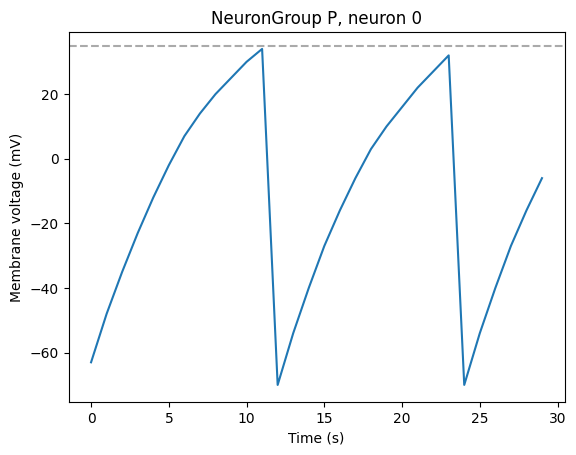

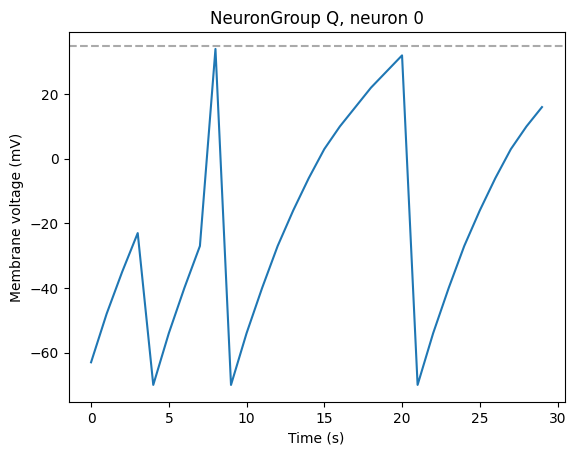

In [13]:
plt.plot(stmPv.t/second,stmPv.v[0]/mV/scf)
plt.axhline(v_th/mV/scf, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
show()

plt.plot(stmQv.t/second,stmQv.v[0]/mV/scf)
plt.axhline(v_th/mV/scf, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup Q, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
show()

In [14]:
print("NeuronGroup P:")
print(f"  {len(spmP.i)} spikes occurred in total, {np.sum(spmP.i == 0)} in neuron 0.")
print("  ", spmP.t[spmP.i == 0])
print("  ", spmP.v[spmP.i == 0])
print("NeuronGroup Q:")
print(f"  {len(spmQ.i)} spikes occurred in total, {np.sum(spmQ.i == 0)} in neuron 0.")
print("  ", spmQ.t[spmQ.i == 0])
print("  ", spmQ.v[spmQ.i == 0])

NeuronGroup P:
  6 spikes occurred in total, 2 in neuron 0.
   [11. 23.] s
   [34. 32.] V
NeuronGroup Q:
  9 spikes occurred in total, 3 in neuron 0.
   [ 3.  8. 20.] s
   [-23.  34.  32.] V
